## Inference Pipeline

## Import dependencies

In [1]:
from auth.auth import S3Connector
from utils.utils import extract_s3_path_from_url
from utils.stac_client import get_product, get_product_content
from dotenv import load_dotenv
import os
import pystac_client
from utils.utils import load_config
import random

In [2]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
BUCKET_NAME = "eodata"
path = "/home/ubuntu/project/sentinel-2-ai-processor/src/cfg/config_dataset.yaml"

config = load_config(config_path=path)

bbox = config["query"]["bbox"]
bbox

[3.2833, 45.3833, 11.2, 50.1833]

In [3]:
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()

In [4]:
# Search for Sentinel-2 products
items_l1c= catalog.search(
    collections=['sentinel-2-l2a'],
    bbox=bbox,
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<80"]
).item_collection()

In [5]:
selected_item = random.choice(items_l1c)
selected_item

<Item id=S2B_MSIL2A_20240525T101559_N0510_R065_T32TMT_20240525T130132>

In [6]:
bucket = s3.Bucket(BUCKET_NAME)
# product_url = extract_s3_path_from_url(selected_item.assets['B02'].href)
# # file_path = get_product(s3_resource=s3_client, bucket_name=BUCKET_NAME,
# #                              object_url=product_url,
# #                              output_path=".")
# product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
#                                      object_url=product_url)

In [7]:
import numpy as np
from PIL import Image
import io

# bands = { 1: 'B02', 2: 'B03', 3: 'B04'}
bands = { 1: 'B02_60m', 2: 'B03_60m', 3: 'B04_60m'}

# Loop through each band
band_data = []
for band_index, band_name in bands.items():
    print(f"Band {band_name}")
    product_url = extract_s3_path_from_url(selected_item.assets[band_name].href)
    product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)
    product_content = Image.open(io.BytesIO(product_content))
    resized_image = product_content.resize((1830, 1830))
    product_content = np.array(product_content)
    band_data.append(product_content)
    print(f"Successfully downloaded product: {product_url}")

Band B02_60m
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/25/S2B_MSIL2A_20240525T101559_N0510_R065_T32TMT_20240525T130132.SAFE/GRANULE/L2A_T32TMT_A037700_20240525T102036/IMG_DATA/R60m/T32TMT_20240525T101559_B02_60m.jp2
Successfully downloaded product: Sentinel-2/MSI/L2A/2024/05/25/S2B_MSIL2A_20240525T101559_N0510_R065_T32TMT_20240525T130132.SAFE/GRANULE/L2A_T32TMT_A037700_20240525T102036/IMG_DATA/R60m/T32TMT_20240525T101559_B02_60m.jp2
Band B03_60m
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/25/S2B_MSIL2A_20240525T101559_N0510_R065_T32TMT_20240525T130132.SAFE/GRANULE/L2A_T32TMT_A037700_20240525T102036/IMG_DATA/R60m/T32TMT_20240525T101559_B03_60m.jp2
Successfully downloaded product: Sentinel-2/MSI/L2A/2024/05/25/S2B_MSIL2A_20240525T101559_N0510_R065_T32TMT_20240525T130132.SAFE/GRANULE/L2A_T32TMT_A037700_20240525T102036/IMG_DATA/R60m/T32TMT_20240525T101559_B03_60m.jp2
Band B04_60m
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/25/S2B_MSIL2A_20240525T101559_N0510_R065_T32

In [8]:
x_data = np.dstack(band_data)

In [9]:
def normalize(data_array):
    """
    Normalize the data array to the range [0, 1].
    """
    normalized_data = []
    valid_masks= []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        result = band_data.copy().astype(np.float32)
        result[valid_mask] = result[valid_mask] / 10000
        result[valid_mask] = np.clip(result[valid_mask], 0, 1)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks)

In [10]:
config = load_config(config_path="/home/ubuntu/project/sentinel-2-ai-compressor/src/results/2025-08-05_15-58-46/config.yaml")
config

{'DATASET': {'bands': ['B02', 'B03', 'B04'],
  'base_dir': '/mnt/disk/dataset/sentinel-ai-processor',
  'version': 'V3'},
 'ENDPOINTS': {'bucket_name': 'eodata',
  'stac': 'https://stac.dataspace.copernicus.eu/v1/',
  'url': 'ttps://eodata.dataspace.copernicus.eu'},
 'MODEL': {'activation': 'relu',
  'encoder_name': 'timm-efficientnet-b2',
  'encoder_weights': 'imagenet',
  'in_channel': 3,
  'model_name': 'Unet',
  'out_channels': 3},
 'TRAINING': {'augmentation': False,
  'batch_size': 8,
  'factor': 0.5,
  'learning_rate': '1e-3',
  'n_epoch': 100,
  'num_workers': 8,
  'optim': 'Adam',
  'resize': 1024,
  'save_metric': 'sam',
  'save_mode': 'min',
  'save_strategy': 'metric',
  'scheduler': True,
  'scheduler_type': 'ReduceLROnPlateau',
  'seed': 42},
 'WANDB': {'project_name': 'sentinel2-ai-compressor', 'track': True}}

In [11]:
from model_zoo.models import define_model
import torch
from utils.torch import load_model_weights

weights_path = f"/home/ubuntu/project/sentinel-2-ai-compressor/src/results/2025-08-05_15-58-46/checkpoints/best_model.pth"
model = define_model(name=config["MODEL"]["model_name"],
                    encoder_name=config["MODEL"]["encoder_name"],
                    in_channel=len(bands),
                    out_channels=len(bands),
                    activation=config["MODEL"]["activation"])

# Load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-12 09:22:07.470 | INFO     | utils.torch:load_model_weights:106 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-compressor/src/results/2025-08-05_15-58-46/checkpoints/best_model.pth



In [12]:
model = model.to(device)
model

Sequential(
  (0): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
     

In [13]:
import cv2
resize = 1024
x_data, x_mask = normalize(x_data)
x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
x_mask = cv2.resize(x_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST).astype(bool)

In [14]:
valid_mask = x_mask

# Prepare tensors for inference
x_tensor = torch.from_numpy(x_data).float().permute(2, 0, 1).unsqueeze(0).to(device)  # [1, C, H, W]

# Inference
model.eval()
with torch.no_grad():
    pred_tensor = model(x_tensor)

# Convert tensors to NumPy
x_np = x_tensor.cpu().numpy()[0].transpose(1, 2, 0)       # [H, W, C]
pred_np = pred_tensor.cpu().numpy()[0].transpose(1, 2, 0) # [H, W, C]

In [15]:
# Apply mask: set invalid pixels to 0
x_np[~valid_mask] = 0.0
pred_np[~valid_mask] = 0.0

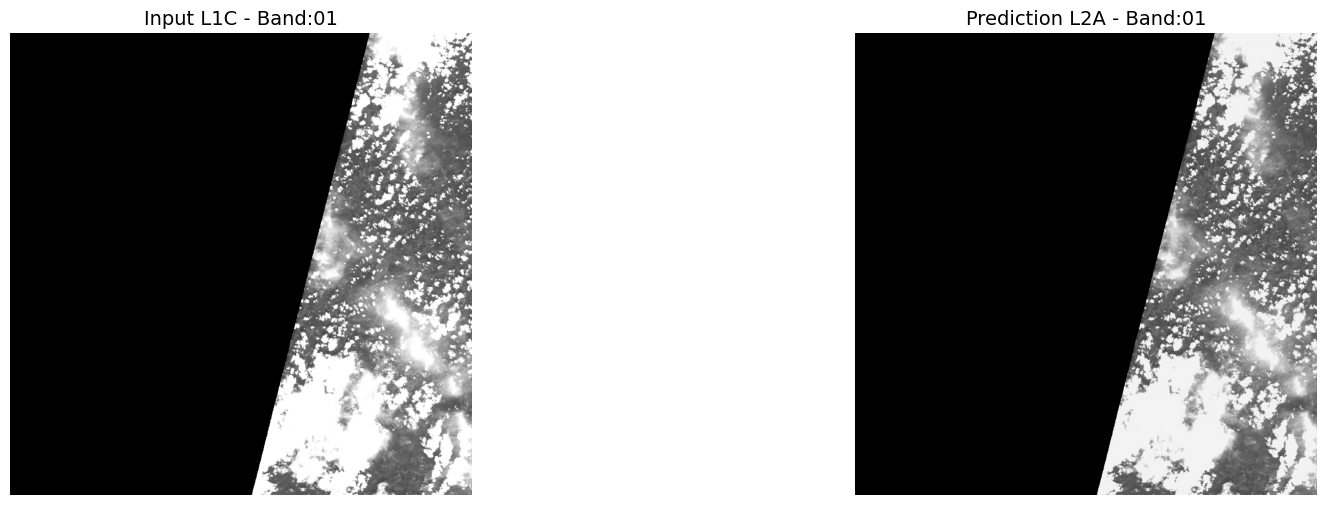

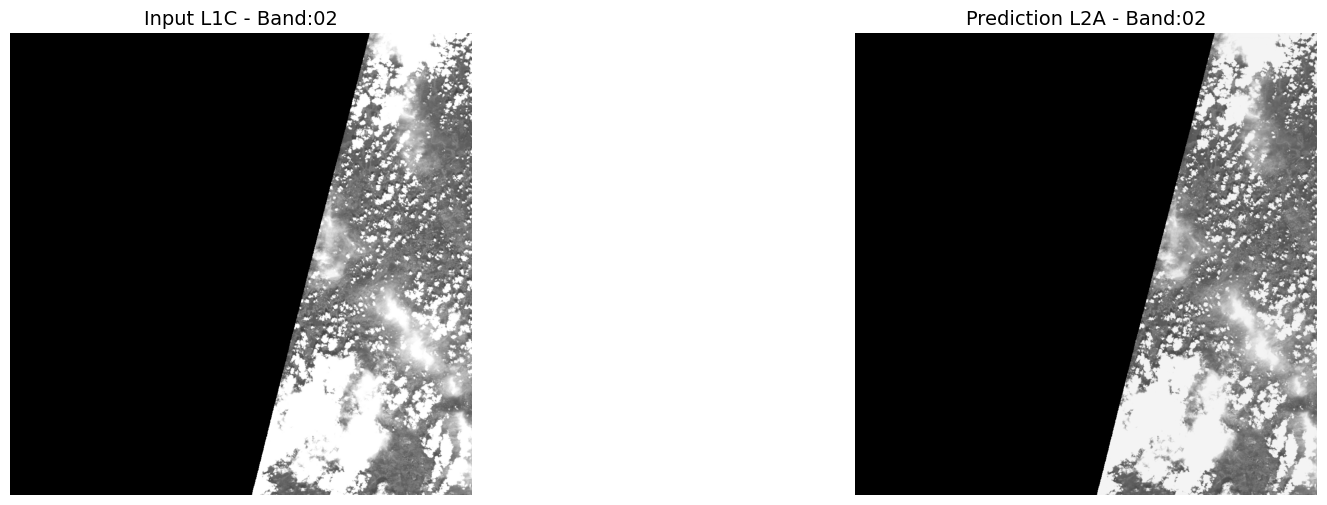

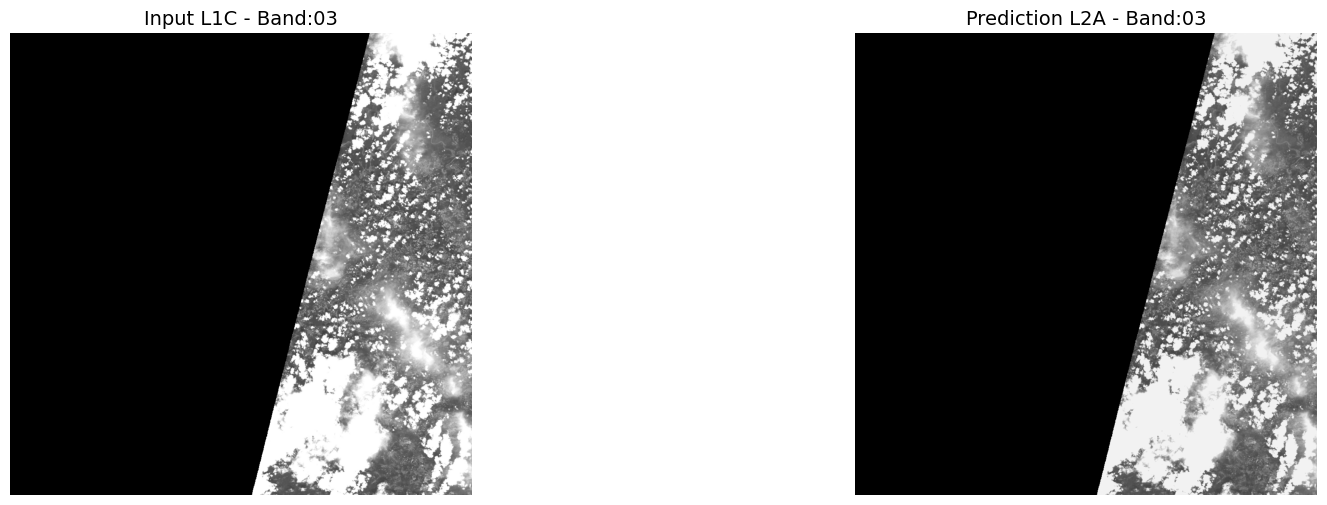

In [16]:
import matplotlib.pyplot as plt
cmap = "Grays_r"
# Plot results for each band
for idx, band in enumerate(bands):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    vmin = 0
    # Input
    im0 = axs[0].imshow(x_np[:, :, idx], cmap=cmap, vmin=x_np[:, :, idx].min(), vmax=x_np[:, :, idx].max())
    axs[0].set_title(f"Input L1C - Band:0{band}", fontsize=14)
    axs[0].axis('off')
    # plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    # Prediction
    im2 = axs[1].imshow(pred_np[:, :, idx], cmap=cmap, vmin=vmin, vmax=pred_np[:, :, idx].max())
    axs[1].set_title(f"Prediction L2A - Band:0{band}", fontsize=14)
    axs[1].axis('off')
    # plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)


In [23]:
# Global dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Clear previous activations
activations.clear()

# Register hook on the deepest layer (last block with 352 channels)
hook_handle = model[0].encoder.blocks[6][1].register_forward_hook(get_activation("deepest_layer"))

# Your existing forward pass
model.eval()
with torch.no_grad():
    pred_tensor = model(x_tensor)

# Extract the deepest layer tensor
deepest_tensor = activations["deepest_layer"]

# Clean up hook
hook_handle.remove()

print(f"Deepest layer tensor shape: {deepest_tensor.shape}")  # Should be [1, 352, H/32, W/32]

Deepest layer tensor shape: torch.Size([1, 352, 32, 32])


In [115]:
# Print input tensor info
print(f"Input tensor (x_tensor) shape: {x_tensor.shape}")
print(f"Input tensor size: {x_tensor.numel():,} elements")

# Print bottleneck tensor info
print(f"Bottleneck tensor shape: {deepest_tensor.shape}")
print(f"Bottleneck tensor size: {deepest_tensor.numel():,} elements")

# Calculate compression ratio
compression_ratio = x_tensor.numel() / deepest_tensor.numel()
print(f"Compression ratio: {compression_ratio:.2f}x smaller")

# Calculate size reduction percentage
size_reduction = (1 - deepest_tensor.numel() / x_tensor.numel()) * 100
print(f"Size reduction: {size_reduction:.1f}%")

# Compare spatial dimensions
input_spatial = x_tensor.shape[2] * x_tensor.shape[3]
bottleneck_spatial = deepest_tensor.shape[2] * deepest_tensor.shape[3]
spatial_compression = input_spatial / bottleneck_spatial

# Compare channel dimensions
print(f"Channel expansion: {x_tensor.shape[1]} -> {deepest_tensor.shape[1]} channels")

Input tensor (x_tensor) shape: torch.Size([1, 3, 1024, 1024])
Input tensor size: 3,145,728 elements
Bottleneck tensor shape: torch.Size([1, 352, 32, 32])
Bottleneck tensor size: 360,448 elements
Compression ratio: 8.73x smaller
Size reduction: 88.5%
Channel expansion: 3 -> 352 channels


In [24]:
import torch

# Calculate tensor sizes in bytes
def get_tensor_size_bytes(tensor):
    return tensor.numel() * tensor.element_size()

def format_bytes(bytes_size):
    """Convert bytes to human readable format"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes_size < 1024.0:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024.0
    return f"{bytes_size:.2f} TB"

# Calculate sizes in bytes
input_bytes = get_tensor_size_bytes(x_tensor)
bottleneck_bytes = get_tensor_size_bytes(deepest_tensor)

print(f"Input tensor (x_tensor):")
print(f"  Shape: {x_tensor.shape}")
print(f"  Size: {input_bytes:,} bytes ({format_bytes(input_bytes)})")

print(f"Bottleneck tensor:")
print(f"  Shape: {deepest_tensor.shape}")
print(f"  Size: {bottleneck_bytes:,} bytes ({format_bytes(bottleneck_bytes)})")

# Calculate compression
compression_ratio_bytes = input_bytes / bottleneck_bytes
save_percentage = (1 - (bottleneck_bytes / input_bytes)) * 100  # Added * 100 for percentage

print(f"Compression:")
print(f"  Ratio: {compression_ratio_bytes:.2f}x smaller")
print(f"  Compression: {save_percentage:.1f}%")
print(f"Data type: {x_tensor.dtype} ({x_tensor.element_size()} bytes per element)")

Input tensor (x_tensor):
  Shape: torch.Size([1, 3, 1024, 1024])
  Size: 12,582,912 bytes (12.00 MB)
Bottleneck tensor:
  Shape: torch.Size([1, 352, 32, 32])
  Size: 1,441,792 bytes (1.38 MB)
Compression:
  Ratio: 8.73x smaller
  Compression: 88.5%
Data type: torch.float32 (4 bytes per element)
